In [1]:
import time
import torch
import json
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss

import boto3
import io

from models_package.models import Teacher, Student
import models_package
from utils.compare_tools import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison
from utils.misc_tools import best_LR, best_LR_wider, train_teacher, train_teacher_wider, retrieve_teacher_class_weights, new_teacher_class_weights

In [35]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
num_epochs = 240 # 200
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 30
step_size = 30
gamma = 0.1
patience = 7  # for early stopping
lmda = 3
batch_size = 12
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])



In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [37]:
len(class_labels)

30

## Test dataloader from utils

In [38]:
from data.data_loader import load_wider

train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]

trainloader, testloader  = load_wider(train_file, test_file, class_labels, batch_size, num_workers)



Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [39]:
# from collections import Counter

# # Iterate through batches in the trainloader
# for batch_idx, batch in enumerate(trainloader):
#     # Only process the first 3 batches
#     if batch_idx >= 3:
#         break

#     # Extract labels for the current batch
#     batch_labels = batch['label']

#     # Convert batch_labels to a list if it's not already (e.g., if it's a tensor)
#     if not isinstance(batch_labels, list):
#         batch_labels = batch_labels.tolist()

#     # Count the frequency of each label in this batch
#     label_counts = Counter(batch_labels)

#     # Print the label counts for this batch
#     print(f"Batch {batch_idx + 1} class counts:")
#     for label in range(30):  # Assuming classes are labeled from 0 to 29
#         print(f"  Class {label}: {label_counts[label]} instances")
#     print("-" * 30)  # Just a separator for clarity

# Train Teacher

## Prep s3 bucket

In [7]:
# Calling the function
model_name = 'resnet32x4_wider'
model_weight_path = 'weights/wider_teacher_resnet32x4_weights.pth'
num_class = 30
data_name = 'wider'  
batch_size = 32  
bucket_name = '210bucket'  

## Load in models

### resnet32x4_wider

In [8]:
# Instantiate the models
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

### resnet8x4_wider

In [9]:
student_name = 'resnet8x4_wider'
student_model = models_package.__dict__[student_name](num_class=30)
student_model.fc = nn.Linear(teacher_model.fc.in_features, 30)

In [10]:
# Optimizer and scheduler for the student model
student_optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# teacher_lr = best_LR_wider('resnet32x4_lr_wider_test', teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)
# teacher_lr

100%|████████████████████████████████████████████████████████████████████████████████████████| 81/81 [01:09<00:00,  1.16it/s]


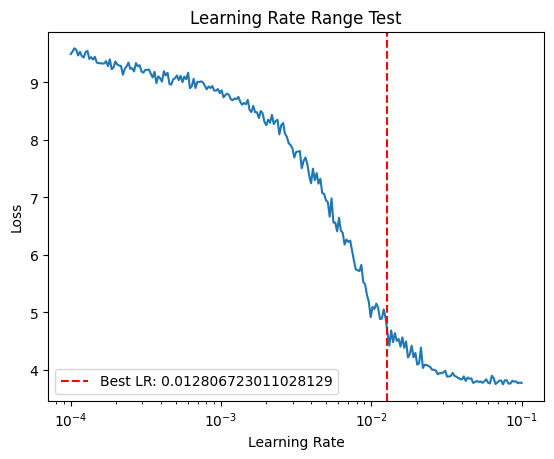

Best learning rate: 0.012806723011028129


0.012806723011028129

In [12]:
student_lr = best_LR_wider('resnet8x4_lr_wider_test', student_model, trainloader, criterion, student_optimizer, student_scheduler, device, num_epochs=3)
student_lr

In [13]:
teacher_lr = 0.0005953788301881531
student_lr = 0.0011397725198066264

## Train Leaderboard Teacher Models

In [14]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [42]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, epochs, patience=5):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        model.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            _, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)


        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0  
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
    
                # Forward pass for validation
                _, val_outputs = model(val_inputs)
    
                val_loss = criterion(val_outputs, val_labels)

                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
            total_val_loss /= num_batches
            val_losses.append(total_val_loss)
            accuracy = total_correct / total_samples
            print(f'*****Epoch {epoch + 1}/{num_epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n')
        # Check for early stopping
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            patience_counter = 0 
            torch.save(model.state_dict(), f'weights/wider/wider_teacher_model_weights_resnet32_4_v2.pth')
            torch.save(model, f'weights/wider/wider_teacher_model_resnet32_4.pth')
        else:
            patience_counter += 1 

        if (patience_counter >= patience):
            print('Early stopping')
            break  

        scheduler.step()
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")

In [ ]:
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs, patience=5)

  5%|████▏                                                                                  | 14/288 [00:01<00:28,  9.77it/s]

In [14]:
# teacher_resnet32x4 = train_teacher_wider('resnet_32x4', teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, num_epochs=240, patience=5)


 31%|██████████████████████████▋                                                           | 100/323 [01:28<03:13,  1.15it/s]

[1, 100] loss: 6.326


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:55<01:47,  1.15it/s]

[1, 200] loss: 3.349


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:22<00:20,  1.15it/s]

[1, 300] loss: 3.200


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[2, 100] loss: 3.067


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[2, 200] loss: 3.029


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[2, 300] loss: 2.955


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[3, 100] loss: 2.917


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[3, 200] loss: 2.842


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[3, 300] loss: 2.843


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[4, 100] loss: 2.754


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[4, 200] loss: 2.818


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[4, 300] loss: 2.770


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[5, 100] loss: 2.743


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[5, 200] loss: 2.724


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[5, 300] loss: 2.712


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[6, 100] loss: 2.679


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[6, 200] loss: 2.679


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[6, 300] loss: 2.694


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[7, 100] loss: 2.642


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[7, 200] loss: 2.624


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[7, 300] loss: 2.641


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[8, 100] loss: 2.603


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[8, 200] loss: 2.617


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[8, 300] loss: 2.587


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[9, 100] loss: 2.584


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[9, 200] loss: 2.542


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[9, 300] loss: 2.533


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[10, 100] loss: 2.485


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:46,  1.15it/s]

[10, 200] loss: 2.508


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[10, 300] loss: 2.532


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[11, 100] loss: 2.503


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[11, 200] loss: 2.481


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[11, 300] loss: 2.498


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[12, 100] loss: 2.451


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[12, 200] loss: 2.434


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[12, 300] loss: 2.474


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[13, 100] loss: 2.375


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[13, 200] loss: 2.430


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[13, 300] loss: 2.473


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[14, 100] loss: 2.405


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[14, 200] loss: 2.376


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[14, 300] loss: 2.395


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[15, 100] loss: 2.418


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[15, 200] loss: 2.343


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[15, 300] loss: 2.361


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[16, 100] loss: 2.330


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[16, 200] loss: 2.373


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[16, 300] loss: 2.341


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[17, 100] loss: 2.254


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[17, 200] loss: 2.353


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[17, 300] loss: 2.350


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[18, 100] loss: 2.220


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[18, 200] loss: 2.318


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[18, 300] loss: 2.317


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[19, 100] loss: 2.228


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[19, 200] loss: 2.254


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[19, 300] loss: 2.257


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[20, 100] loss: 2.205


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[20, 200] loss: 2.185


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[20, 300] loss: 2.250


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[21, 100] loss: 2.137


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:46,  1.15it/s]

[21, 200] loss: 2.214


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[21, 300] loss: 2.244


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[22, 100] loss: 2.175


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[22, 200] loss: 2.161


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[22, 300] loss: 2.148


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[23, 100] loss: 2.129


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[23, 200] loss: 2.141


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[23, 300] loss: 2.164


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[24, 100] loss: 2.128


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[24, 200] loss: 2.119


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[24, 300] loss: 2.136


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[25, 100] loss: 2.111


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[25, 200] loss: 2.069


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[25, 300] loss: 2.076


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[26, 100] loss: 2.024


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[26, 200] loss: 2.059


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[26, 300] loss: 2.087


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[27, 100] loss: 2.029


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[27, 200] loss: 2.028


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[27, 300] loss: 2.049


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[28, 100] loss: 2.013


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[28, 200] loss: 2.015


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[28, 300] loss: 2.005


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[29, 100] loss: 1.964


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[29, 200] loss: 1.963


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[29, 300] loss: 2.031


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[30, 100] loss: 1.939


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[30, 200] loss: 1.960


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[30, 300] loss: 1.984


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:13,  1.15it/s]

[31, 100] loss: 1.818


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[31, 200] loss: 1.778


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[31, 300] loss: 1.734


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[32, 100] loss: 1.659


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[32, 200] loss: 1.722


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[32, 300] loss: 1.724


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[33, 100] loss: 1.655


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[33, 200] loss: 1.670


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[33, 300] loss: 1.710


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[34, 100] loss: 1.746


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[34, 200] loss: 1.690


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[34, 300] loss: 1.650


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:13,  1.15it/s]

[35, 100] loss: 1.648


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[35, 200] loss: 1.667


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[35, 300] loss: 1.661


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:13,  1.15it/s]

[36, 100] loss: 1.662


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[36, 200] loss: 1.630


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[36, 300] loss: 1.644


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[37, 100] loss: 1.665


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[37, 200] loss: 1.629


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[37, 300] loss: 1.638


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[38, 100] loss: 1.603


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[38, 200] loss: 1.676


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[38, 300] loss: 1.639


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[39, 100] loss: 1.656


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[39, 200] loss: 1.640


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[39, 300] loss: 1.628


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[40, 100] loss: 1.610


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[40, 200] loss: 1.595


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[40, 300] loss: 1.638


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[41, 100] loss: 1.590


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[41, 200] loss: 1.634


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[41, 300] loss: 1.646


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[42, 100] loss: 1.548


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[42, 200] loss: 1.598


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[42, 300] loss: 1.626


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[43, 100] loss: 1.538


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:46,  1.15it/s]

[43, 200] loss: 1.625


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[43, 300] loss: 1.612


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[44, 100] loss: 1.571


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[44, 200] loss: 1.606


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[44, 300] loss: 1.583


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[45, 100] loss: 1.573


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[45, 200] loss: 1.554


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[45, 300] loss: 1.606


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:13,  1.15it/s]

[46, 100] loss: 1.545


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:46,  1.15it/s]

[46, 200] loss: 1.620


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[46, 300] loss: 1.570


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[47, 100] loss: 1.523


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[47, 200] loss: 1.572


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[47, 300] loss: 1.560


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[48, 100] loss: 1.522


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[48, 200] loss: 1.518


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[48, 300] loss: 1.599


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[49, 100] loss: 1.558


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[49, 200] loss: 1.537


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[49, 300] loss: 1.566


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[50, 100] loss: 1.554


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[50, 200] loss: 1.518


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[50, 300] loss: 1.534


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[51, 100] loss: 1.520


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[51, 200] loss: 1.543


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[51, 300] loss: 1.531


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[52, 100] loss: 1.513


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[52, 200] loss: 1.520


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[52, 300] loss: 1.567


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[53, 100] loss: 1.497


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[53, 200] loss: 1.513


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[53, 300] loss: 1.505


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[54, 100] loss: 1.463


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[54, 200] loss: 1.510


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[54, 300] loss: 1.566


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[55, 100] loss: 1.486


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[55, 200] loss: 1.475


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[55, 300] loss: 1.495


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[56, 100] loss: 1.484


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[56, 200] loss: 1.460


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[56, 300] loss: 1.468


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[57, 100] loss: 1.524


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[57, 200] loss: 1.438


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[57, 300] loss: 1.480


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[58, 100] loss: 1.473


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[58, 200] loss: 1.443


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[58, 300] loss: 1.498


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[59, 100] loss: 1.447


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[59, 200] loss: 1.451


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[59, 300] loss: 1.469


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[60, 100] loss: 1.451


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[60, 200] loss: 1.431


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[60, 300] loss: 1.446


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[61, 100] loss: 1.398


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[61, 200] loss: 1.420


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[61, 300] loss: 1.395


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[62, 100] loss: 1.386


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[62, 200] loss: 1.371


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[62, 300] loss: 1.362


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[63, 100] loss: 1.359


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[63, 200] loss: 1.358


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[63, 300] loss: 1.395


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[64, 100] loss: 1.311


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[64, 200] loss: 1.370


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[64, 300] loss: 1.387


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[65, 100] loss: 1.360


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[65, 200] loss: 1.392


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[65, 300] loss: 1.317


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[66, 100] loss: 1.350


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[66, 200] loss: 1.369


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[66, 300] loss: 1.392


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[67, 100] loss: 1.325


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[67, 200] loss: 1.370


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[67, 300] loss: 1.380


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[68, 100] loss: 1.374


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[68, 200] loss: 1.356


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[68, 300] loss: 1.369


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[69, 100] loss: 1.401


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[69, 200] loss: 1.387


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[69, 300] loss: 1.316


 31%|██████████████████████████▋                                                           | 100/323 [01:27<03:14,  1.15it/s]

[70, 100] loss: 1.310


 62%|█████████████████████████████████████████████████████▎                                | 200/323 [02:54<01:47,  1.15it/s]

[70, 200] loss: 1.403


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 300/323 [04:21<00:20,  1.15it/s]

[70, 300] loss: 1.382


100%|██████████████████████████████████████████████████████████████████████████████████████| 323/323 [04:41<00:00,  1.15it/s]

Early stopping
Finished Training Teacher


In [15]:
## backup locally
# Save the student and teacher model weights and architecture
torch.save(teacher_model.state_dict(), 'weights/wider/wider_teacher_model_weights_resnet32_4.pth')
torch.save(teacher_model, 'weights/wider/wider_teacher_model_resnet32_4.pth')
print('student weights and architecture saved and exported')

student weights and architecture saved and exported


In [18]:
###################### Saving weights and movel using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 



# Teacher Model
#### IMPORTANT!!!!! Change the file name so that you do not overwrite the existing files
teacher_model_weights_path = 'weights/teacher_model_resnet32x4_wider.pth'
teacher_model_path = 'models/testing_teacher_model_resnet32x4_wider.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


teacher weights and architecture saved and exported to S3


## Model Evaluation

### Pull Model from S3

In [13]:
# Initialize a session using Boto3 again 
session = boto3.session.Session()

s3 = session.client('s3')
bucket_name = '210bucket'  

teacher_model_weights_s3_path = 'weights/teacher_model_resnet32x4_wider.pth'
# student_model_weights_s3_path = 'weights/testing_student_model_weights_rkd_prof.pth'

# Read files directly into memory
teacher_model_weights_buffer = io.BytesIO()
# student_model_weights_buffer = io.BytesIO()

s3.download_fileobj(bucket_name, teacher_model_weights_s3_path, teacher_model_weights_buffer)
# s3.download_fileobj(bucket_name, student_model_weights_s3_path, student_model_weights_buffer)

# Load the weights into the models
teacher_model_weights_buffer.seek(0)  # Move to the beginning of the buffer
# student_model_weights_buffer.seek(0)  

######## MAKE SURE THAT YOU HAVE THE CORRECT MODELS FOR WEIGHTS ########
# Teacher
teacher_name = 'resnet32x4_wider'
teacher_model = models_package.__dict__[teacher_name](num_class=30)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 30)
teacher_model.load_state_dict(torch.load(teacher_model_weights_buffer))
teacher_model.eval()
# # Student
# student_model = CustomResNet18()
# student_model.load_state_dict(torch.load(student_model_weights_buffer))


ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [ ]:

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs[0], dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs[0], dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [ ]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)['metrics']
print(performance_metrics)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]

student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')